In [17]:
class STLTemporalIntegration:
    """
    A class for implementing Seasonal-Trend decomposition with Temporal Integration
    for business KPI analysis.
    """

    def __init__(self, data, date_column, value_column, period=None):
        """
        Initialize with time series data.

        Parameters:
        -----------
        data : pandas DataFrame
            DataFrame containing the time series data
        date_column : str
            Name of the column containing datetime values
        value_column : str
            Name of the column containing KPI values
        period : int, optional
            The seasonal period (e.g., 7 for weekly, 12 for monthly, 365 for annual)
            If None, it will be inferred from the data frequency
        """
        self.df = data.copy()
        self.date_col = date_column
        self.value_col = value_column

        # Ensure date column is datetime type
        self.df[self.date_col] = pd.to_datetime(self.df[self.date_col])

        # Sort by date
        self.df = self.df.sort_values(by=self.date_col).reset_index(drop=True)

        # Set date as index
        self.df.set_index(self.date_col, inplace=True)

        # Infer frequency if period is not provided
        if period is None:
            # Try to infer frequency from data
            freq = pd.infer_freq(self.df.index)
            if freq == 'D':
                self.period = 7  # Daily data, weekly seasonality
            elif freq == 'B':
                self.period = 5  # Business days, weekly seasonality
            elif freq in ['M', 'MS']:
                self.period = 12  # Monthly data, annual seasonality
            elif freq in ['Q', 'QS']:
                self.period = 4  # Quarterly data, annual seasonality
            else:
                self.period = 7  # Default to weekly
                print(f"Warning: Could not infer seasonality period from frequency {freq}. Defaulting to 7.")
        else:
            self.period = period

        # Initialize decomposition components
        self.trend = None
        self.seasonal = None
        self.resid = None

        print(f"Initialized with {len(self.df)} observations and seasonal period of {self.period}")

    def decompose(self, seasonal_deg=1, trend_deg=1, low_pass_deg=1,
                  seasonal_jump=1, trend_jump=1, low_pass_jump=1,
                  robust=False):
        """
        Perform STL decomposition on the time series.

        Parameters:
        -----------
        seasonal_deg : int
            Degree of seasonal LOESS
        trend_deg : int
            Degree of trend LOESS
        low_pass_deg : int
            Degree of low-pass LOESS
        seasonal_jump : int
            Jump for seasonal LOESS
        trend_jump : int
            Jump for trend LOESS
        low_pass_jump : int
            Jump for low-pass LOESS
        robust : bool
            Whether to use robust fitting

        Returns:
        --------
        self : STLTemporalIntegration
            Returns self for method chaining
        """
        # Handle missing values if any
        if self.df[self.value_col].isnull().any():
            print("Warning: Missing values detected. Interpolating...")
            self.df[self.value_col] = self.df[self.value_col].interpolate(method='linear')

        # Perform STL decomposition
        stl = STL(self.df[self.value_col],
                  period=self.period,
                  seasonal_deg=seasonal_deg,
                  trend_deg=trend_deg,
                  low_pass_deg=low_pass_deg,
                  seasonal_jump=seasonal_jump,
                  trend_jump=trend_jump,
                  low_pass_jump=low_pass_jump,
                  robust=robust)

        result = stl.fit()

        # Store decomposition components
        self.trend = result.trend
        self.seasonal = result.seasonal
        self.resid = result.resid

        # Create DataFrame with decomposition results
        self.decomposition = pd.DataFrame({
            'original': self.df[self.value_col],
            'trend': self.trend,
            'seasonal': self.seasonal,
            'remainder': self.resid,
            'deseasonalized': self.df[self.value_col] - self.seasonal
        }, index=self.df.index)

        print(f"Decomposition completed. Components extracted: trend, seasonal, remainder")
        return self

    def validate_decomposition(self):
        """
        Validate the quality of the decomposition using statistical tests.

        Returns:
        --------
        dict
            Dictionary containing validation metrics
        """
        if self.trend is None:
            raise ValueError("Decomposition has not been performed. Call decompose() first.")

        # Check if seasonal component captures expected pattern
        # Calculate autocorrelation of seasonal component at seasonal lag
        seasonal_autocorr = self.seasonal.autocorr(lag=self.period)

        # Check for remaining seasonality in the residuals
        resid_autocorr = self.resid.autocorr(lag=self.period)

        # Check for correlation between components (should be low)
        trend_seasonal_corr, _ = pearsonr(self.trend, self.seasonal)
        trend_resid_corr, _ = pearsonr(self.trend, self.resid)
        seasonal_resid_corr, _ = pearsonr(self.seasonal, self.resid)

        # Verify conservation of mean (Lemma 1)
        original_mean = self.df[self.value_col].mean()
        trend_mean = self.trend.mean()
        mean_diff_pct = abs(original_mean - trend_mean) / original_mean * 100

        # Return validation metrics
        validation = {
            'seasonal_autocorrelation': seasonal_autocorr,
            'residual_seasonal_autocorrelation': resid_autocorr,
            'trend_seasonal_correlation': trend_seasonal_corr,
            'trend_residual_correlation': trend_resid_corr,
            'seasonal_residual_correlation': seasonal_resid_corr,
            'original_mean': original_mean,
            'trend_mean': trend_mean,
            'mean_difference_pct': mean_diff_pct
        }

        # Print validation summary
        print("\nDecomposition Validation:")
        print(f"Seasonal autocorrelation: {seasonal_autocorr:.4f} (should be high)")
        print(f"Residual seasonal autocorrelation: {resid_autocorr:.4f} (should be close to 0)")
        print(f"Trend-Seasonal correlation: {trend_seasonal_corr:.4f} (should be close to 0)")
        print(f"Trend-Residual correlation: {trend_resid_corr:.4f} (should be close to 0)")
        print(f"Seasonal-Residual correlation: {seasonal_resid_corr:.4f} (should be close to 0)")
        print(f"Original mean: {original_mean:.4f}")
        print(f"Trend mean: {trend_mean:.4f}")
        print(f"Mean difference: {mean_diff_pct:.2f}% (should be close to 0)")

        return validation

    def temporal_integration(self, start_date=None, end_date=None, component='trend',
                            weighted=False, lambda_weight=0.1, normalize=False):
        """
        Calculate temporal integration over a specified time interval.

        Parameters:
        -----------
        start_date : datetime or str, optional
            Start date for integration. If None, uses the first date.
        end_date : datetime or str, optional
            End date for integration. If None, uses the last date.
        component : str, optional
            Component to integrate: 'trend', 'original', 'deseasonalized'
        weighted : bool, optional
            Whether to apply exponential weighting
        lambda_weight : float, optional
            Rate parameter for exponential weighting
        normalize : bool, optional
            Whether to normalize by time interval length

        Returns:
        --------
        float
            The temporal integration value
        """
        if self.trend is None:
            raise ValueError("Decomposition has not been performed. Call decompose() first.")

        # Set default dates if not provided
        if start_date is None:
            start_date = self.df.index.min()
        else:
            start_date = pd.to_datetime(start_date)

        if end_date is None:
            end_date = self.df.index.max()
        else:
            end_date = pd.to_datetime(end_date)

        # Get data for the specified time interval
        mask = (self.decomposition.index >= start_date) & (self.decomposition.index <= end_date)
        subset = self.decomposition[mask]

        if len(subset) == 0:
            raise ValueError(f"No data found between {start_date} and {end_date}")

        # Select component to integrate
        if component == 'trend':
            values = subset['trend']
        elif component == 'original':
            values = subset['original']
        elif component == 'deseasonalized':
            values = subset['deseasonalized']
        else:
            raise ValueError(f"Unknown component: {component}")

        # Calculate time differences in days
        time_deltas = [(t - subset.index[0]).total_seconds() / (24*3600)
                       for t in subset.index]

        # Apply weighting if requested
        if weighted:
            # Calculate exponential weights
            max_time = time_deltas[-1]
            weights = np.exp(lambda_weight * (np.array(time_deltas) - max_time))
            weighted_values = values * weights

            # Perform numerical integration using trapezoidal rule
            integration = integrate.trapezoid(weighted_values, time_deltas)
        else:
            # Perform numerical integration using trapezoidal rule
            integration = integrate.trapezoid(values, time_deltas)

        # Normalize if requested
        if normalize:
            time_span = time_deltas[-1]
            integration = integration / time_span

        return integration

    def compare_integrations(self, intervals, component='trend', weighted=False,
                           lambda_weight=0.1, normalize=True):
        """
        Compare temporal integrations across multiple time intervals.

        Parameters:
        -----------
        intervals : list of tuples
            List of (start_date, end_date, label) tuples defining intervals
        component : str, optional
            Component to integrate
        weighted : bool, optional
            Whether to apply exponential weighting
        lambda_weight : float, optional
            Rate parameter for exponential weighting
        normalize : bool, optional
            Whether to normalize by time interval length

        Returns:
        --------
        pandas DataFrame
            DataFrame with integration results for each interval
        """
        results = []

        for start_date, end_date, label in intervals:
            # Calculate integrations for different components
            trend_integration = self.temporal_integration(
                start_date, end_date, 'trend', weighted, lambda_weight, normalize)

            original_integration = self.temporal_integration(
                start_date, end_date, 'original', weighted, lambda_weight, normalize)

            deseasonalized_integration = self.temporal_integration(
                start_date, end_date, 'deseasonalized', weighted, lambda_weight, normalize)

            # Calculate time span in days
            start = pd.to_datetime(start_date)
            end = pd.to_datetime(end_date)
            span_days = (end - start).total_seconds() / (24*3600)

            results.append({
                'interval': label,
                'start_date': start,
                'end_date': end,
                'span_days': span_days,
                'trend_integration': trend_integration,
                'original_integration': original_integration,
                'deseasonalized_integration': deseasonalized_integration,
                'trend_vs_original_diff_pct': (trend_integration - original_integration) / original_integration * 100 if original_integration != 0 else np.nan
            })

        return pd.DataFrame(results)

    def plot_decomposition(self, start_date=None, end_date=None, figsize=(15, 12)):
        """
        Plot the original series and its decomposition components.

        Parameters:
        -----------
        start_date : datetime or str, optional
            Start date for plotting
        end_date : datetime or str, optional
            End date for plotting
        figsize : tuple, optional
            Figure size

        Returns:
        --------
        matplotlib figure
            The figure containing the plots
        """
        if self.trend is None:
            raise ValueError("Decomposition has not been performed. Call decompose() first.")

        # Set default dates if not provided
        if start_date is None:
            start_date = self.df.index.min()
        else:
            start_date = pd.to_datetime(start_date)

        if end_date is None:
            end_date = self.df.index.max()
        else:
            end_date = pd.to_datetime(end_date)

        # Get data for the specified time interval
        mask = (self.decomposition.index >= start_date) & (self.decomposition.index <= end_date)
        subset = self.decomposition[mask]

        # Create figure with subplots
        fig, axes = plt.subplots(5, 1, figsize=figsize, sharex=True)

        # Plot original series
        subset['original'].plot(ax=axes[0], color='blue')
        axes[0].set_title('Original Time Series')
        axes[0].grid(True)

        # Plot trend component
        subset['trend'].plot(ax=axes[1], color='red')
        axes[1].set_title('Trend Component')
        axes[1].grid(True)

        # Plot seasonal component
        subset['seasonal'].plot(ax=axes[2], color='green')
        axes[2].set_title('Seasonal Component')
        axes[2].grid(True)

        # Plot remainder component
        subset['remainder'].plot(ax=axes[3], color='purple')
        axes[3].set_title('Remainder Component')
        axes[3].grid(True)

        # Plot deseasonalized series
        subset['deseasonalized'].plot(ax=axes[4], color='orange')
        subset['trend'].plot(ax=axes[4], color='red', linestyle='--')
        axes[4].set_title('Deseasonalized Series vs Trend')
        axes[4].grid(True)
        axes[4].legend(['Deseasonalized', 'Trend'])

        # Format x-axis
        for ax in axes:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())

        plt.tight_layout()
        plt.xticks(rotation=45)

        return fig

    def plot_trend_integration(self, start_date=None, end_date=None, figsize=(15, 6)):
        """
        Visualize the trend integration as the area under the curve.

        Parameters:
        -----------
        start_date : datetime or str, optional
            Start date for integration visualization
        end_date : datetime or str, optional
            End date for integration visualization
        figsize : tuple, optional
            Figure size

        Returns:
        --------
        matplotlib figure
            The figure containing the plot
        """
        if self.trend is None:
            raise ValueError("Decomposition has not been performed. Call decompose() first.")

        # Set default dates if not provided
        if start_date is None:
            start_date = self.df.index.min()
        else:
            start_date = pd.to_datetime(start_date)

        if end_date is None:
            end_date = self.df.index.max()
        else:
            end_date = pd.to_datetime(end_date)

        # Get data for the specified time interval
        mask = (self.decomposition.index >= start_date) & (self.decomposition.index <= end_date)
        subset = self.decomposition[mask].copy()

        # Calculate integration value
        integration_value = self.temporal_integration(
            start_date, end_date, component='trend', normalize=False)
        normalized_integration = self.temporal_integration(
            start_date, end_date, component='trend', normalize=True)

        # Create figure
        fig, ax = plt.subplots(figsize=figsize)

        # Plot trend component
        ax.plot(subset.index, subset['trend'], color='red', linewidth=2)

        # Fill area under the curve
        ax.fill_between(subset.index, subset['trend'], alpha=0.3, color='red')

        # Add horizontal line at y=0
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

        # Add annotations
        ax.set_title(f'Trend Component Integration (Area Under the Curve)')
        ax.set_xlabel('Date')
        ax.set_ylabel('Trend Value')
        ax.grid(True)

        # Add integration value as text
        span_days = (end_date - start_date).total_seconds() / (24*3600)
        ax.text(0.02, 0.95,
                f'Time Period: {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}\n'
                f'Duration: {span_days:.1f} days\n'
                f'Total Integration: {integration_value:.2f}\n'
                f'Normalized Integration: {normalized_integration:.2f}',
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
                fontsize=10, verticalalignment='top')

        plt.tight_layout()

        return fig

    def plot_comparative_integrations(self, result_df, figsize=(12, 6)):
        """
        Plot comparison of integrations across different intervals.

        Parameters:
        -----------
        result_df : pandas DataFrame
            Results from compare_integrations method
        figsize : tuple, optional
            Figure size

        Returns:
        --------
        matplotlib figure
            The figure containing the plot
        """
        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Plot comparison of trend vs original integrations
        barwidth = 0.35
        x = np.arange(len(result_df))

        ax1.bar(x - barwidth/2, result_df['trend_integration'], width=barwidth,
               label='Trend Integration', color='red', alpha=0.7)
        ax1.bar(x + barwidth/2, result_df['original_integration'], width=barwidth,
               label='Original Integration', color='blue', alpha=0.7)

        ax1.set_xlabel('Interval')
        ax1.set_ylabel('Integration Value')
        ax1.set_title('Comparison of Integration Methods')
        ax1.set_xticks(x)
        ax1.set_xticklabels(result_df['interval'], rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Add percentage difference labels
        for i, row in enumerate(result_df.itertuples()):
            diff_pct = row.trend_vs_original_diff_pct
            if not np.isnan(diff_pct):
                color = 'green' if abs(diff_pct) < 10 else 'red'
                ax1.text(i, max(row.trend_integration, row.original_integration) + 0.5,
                       f"{diff_pct:.1f}%", ha='center', color=color, fontweight='bold')

        # Plot normalized trend integrations
        sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
                   palette='Reds_r')
        ax2.set_xlabel('Interval')
        ax2.set_ylabel('Normalized Trend Integration')
        ax2.set_title('Normalized Trend Integration by Interval')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
        ax2.grid(True, alpha=0.3)

        # Add span days as text
        for i, row in enumerate(result_df.itertuples()):
            ax2.text(i, row.trend_integration/2,
                   f"{row.span_days:.0f} days", ha='center', color='white', fontweight='bold')

        plt.tight_layout()

        return fig


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from scipy import integrate
from scipy.stats import pearsonr
import seaborn as sns


def generate_synthetic_kpi_data(start_date='2024-01-01', periods=365, freq='D',
                               trend_factor=0.05, seasonal_amplitude=10,
                               seasonal_period=7, noise_level=2,
                               event_impacts=None):
    """
    Generate synthetic business KPI data with trend, seasonality, and random events.

    Parameters:
    -----------
    start_date : str
        Start date for the time series
    periods : int
        Number of periods to generate
    freq : str
        Frequency of the data ('D' for daily, 'W' for weekly, etc.)
    trend_factor : float
        Slope of the linear trend component
    seasonal_amplitude : float
        Amplitude of the seasonal component
    seasonal_period : int
        Period of the seasonal component
    noise_level : float
        Standard deviation of the noise component
    event_impacts : dict, optional
        Dictionary mapping dates to impact values for special events

    Returns:
    --------
    pandas DataFrame
        DataFrame containing the synthetic KPI data
    """
    # Generate date range
    dates = pd.date_range(start=start_date, periods=periods, freq=freq)

    # Generate linear trend
    trend = np.arange(periods) * trend_factor

    # Generate seasonal component
    seasonal = seasonal_amplitude * np.sin(2 * np.pi * np.arange(periods) / seasonal_period)

    # Generate noise component
    noise = np.random.normal(0, noise_level, periods)

    # Combine components
    kpi = trend + seasonal + noise

    # Add event impacts if provided
    if event_impacts:
        for date, impact in event_impacts.items():
            if date in dates:
                idx = dates.get_loc(date)
                kpi[idx] += impact

                # Add decay effect for a few days after the event
                decay_days = 5
                for i in range(1, decay_days + 1):
                    if idx + i < len(kpi):
                        kpi[idx + i] += impact * (1 - i/decay_days)

    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'kpi_value': kpi
    })

    return df

In [19]:
# Example usage with synthetic data
def demonstrate_with_synthetic_data():
    # Generate synthetic daily sales data with weekly seasonality
    # and monthly promotional events

    # Define event impacts (e.g., marketing campaigns, promotions)
    events = {
        '2022-02-15': 15,  # Valentine's Day promotion
        '2022-04-15': 20,  # Easter promotion
        '2022-07-04': 25,  # Independence Day event
        '2022-11-25': 30,  # Black Friday sale
        '2022-12-15': 35   # Christmas promotion
    }

    # Generate data
    data = generate_synthetic_kpi_data(
        start_date='2022-01-01',
        periods=365,
        freq='D',
        trend_factor=0.1,            # Steady upward trend
        seasonal_amplitude=15,       # Strong weekly seasonality
        seasonal_period=7,           # Weekly pattern
        noise_level=5,               # Moderate noise
        event_impacts=events         # Special events
    )

    print("Generated synthetic daily sales data with weekly seasonality and special events")

    # Initialize and run the analysis
    stl_ti = STLTemporalIntegration(data, 'date', 'kpi_value', period=7)

    # Perform decomposition
    stl_ti.decompose(
        seasonal_deg=1,    # Linear seasonal fitting
        trend_deg=1,       # Linear trend fitting
        robust=True        # Use robust fitting to handle outliers
    )

    # Validate decomposition
    validation = stl_ti.validate_decomposition()

    # Plot decomposition
    fig1 = stl_ti.plot_decomposition()
    plt.savefig('stl_decomposition.png')

    # Define quarterly intervals for comparison
    quarterly_intervals = [
        ('2022-01-01', '2022-03-31', 'Q1'),
        ('2022-04-01', '2022-06-30', 'Q2'),
        ('2022-07-01', '2022-09-30', 'Q3'),
        ('2022-10-01', '2022-12-31', 'Q4')
    ]

    # Compare integrations across quarters
    quarterly_results = stl_ti.compare_integrations(
        quarterly_intervals,
        normalize=True      # Normalize by time period for fair comparison
    )

    print("\nQuarterly Temporal Integration Results:")
    print(quarterly_results[['interval', 'span_days', 'trend_integration',
                             'original_integration', 'trend_vs_original_diff_pct']])

    # Plot comparison
    fig2 = stl_ti.plot_comparative_integrations(quarterly_results)
    plt.savefig('quarterly_comparison.png')

    # Visualize trend integration for a specific period
    fig3 = stl_ti.plot_trend_integration('2022-07-01', '2022-09-30')
    plt.savefig('q3_trend_integration.png')

    # Compare high-season vs low-season
    seasonal_intervals = [
        ('2022-11-01', '2022-12-31', 'Holiday Season'),
        ('2022-02-01', '2022-03-31', 'Low Season')
    ]

    seasonal_results = stl_ti.compare_integrations(
        seasonal_intervals,
        normalize=True
    )

    print("\nSeasonal Comparison Results:")
    print(seasonal_results[['interval', 'span_days', 'trend_integration',
                           'original_integration', 'trend_vs_original_diff_pct']])

    # Plot seasonal comparison
    fig4 = stl_ti.plot_comparative_integrations(seasonal_results)
    plt.savefig('seasonal_comparison.png')

    return stl_ti, quarterly_results, seasonal_results

Generated synthetic daily sales data with weekly seasonality and special events
Initialized with 365 observations and seasonal period of 7
Decomposition completed. Components extracted: trend, seasonal, remainder

Decomposition Validation:
Seasonal autocorrelation: 0.9934 (should be high)
Residual seasonal autocorrelation: -0.1829 (should be close to 0)
Trend-Seasonal correlation: -0.0154 (should be close to 0)
Trend-Residual correlation: 0.1201 (should be close to 0)
Seasonal-Residual correlation: -0.0360 (should be close to 0)
Original mean: 18.9543
Trend mean: 18.3564
Mean difference: 3.15% (should be close to 0)

Quarterly Temporal Integration Results:
  interval  span_days  trend_integration  original_integration  \
0       Q1       89.0           5.286542              5.576035   
1       Q2       90.0          13.151445             13.905072   
2       Q3       91.0          22.904323             23.095012   
3       Q4       91.0          31.715200             33.192045   

   t

/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:511: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:516: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:511: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/

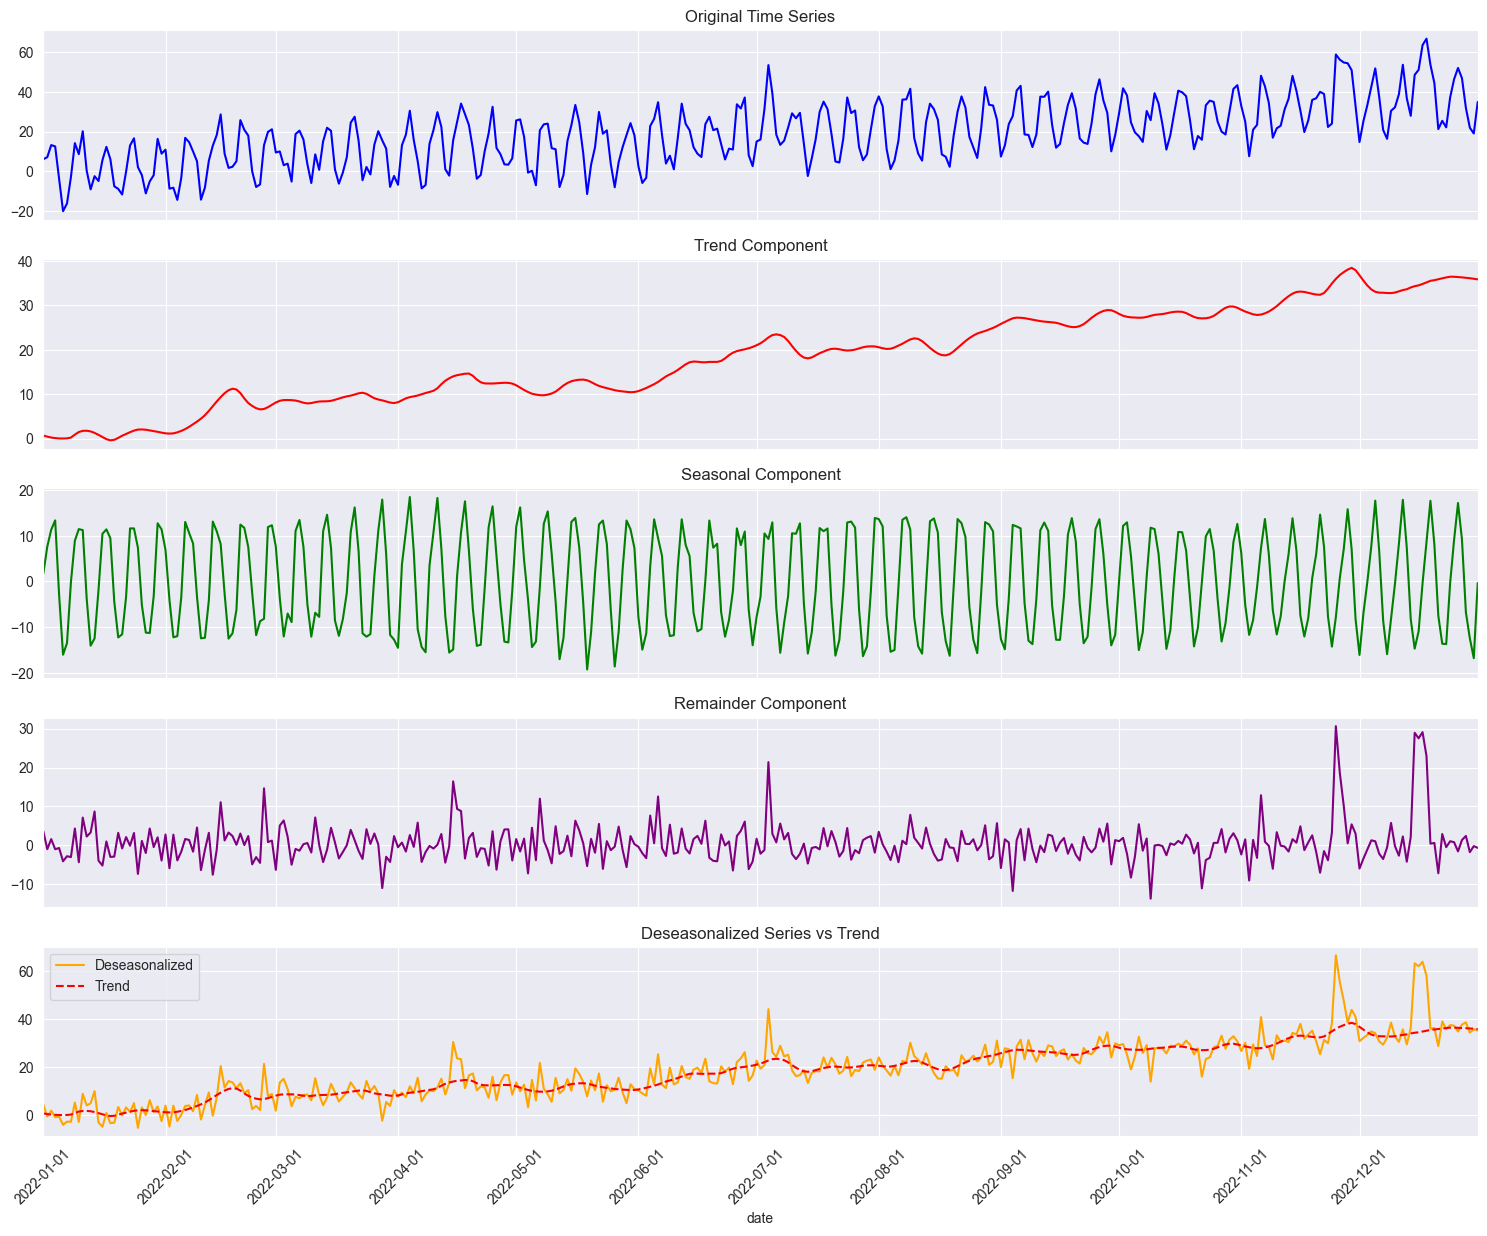

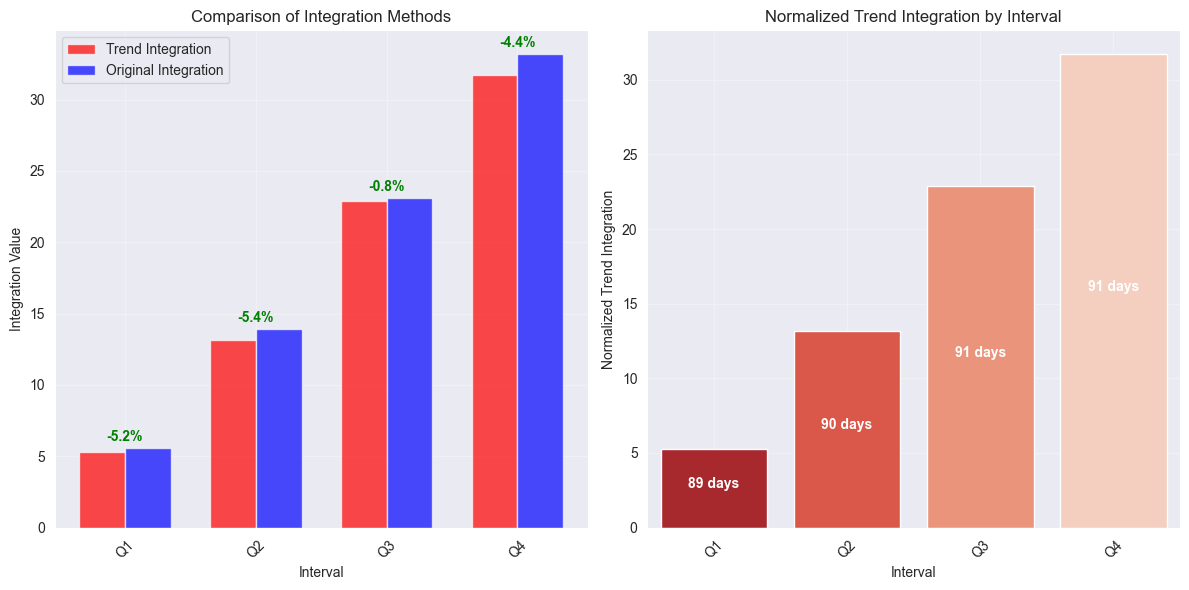

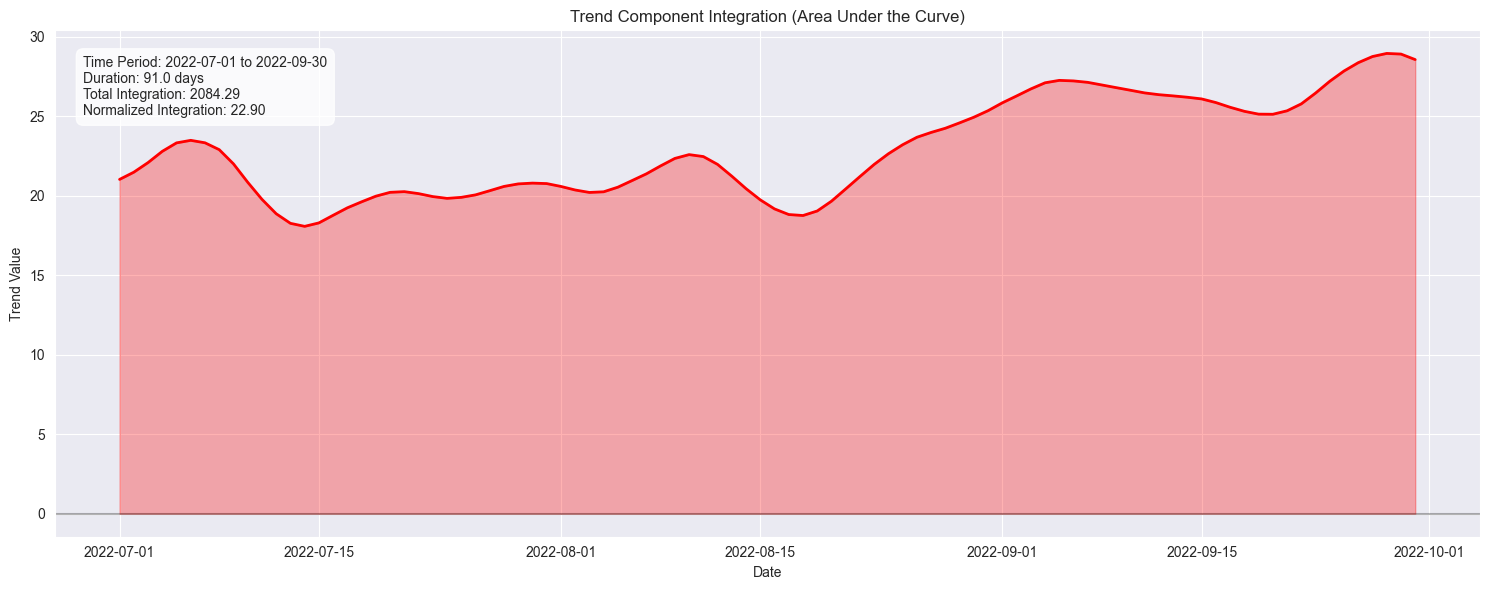

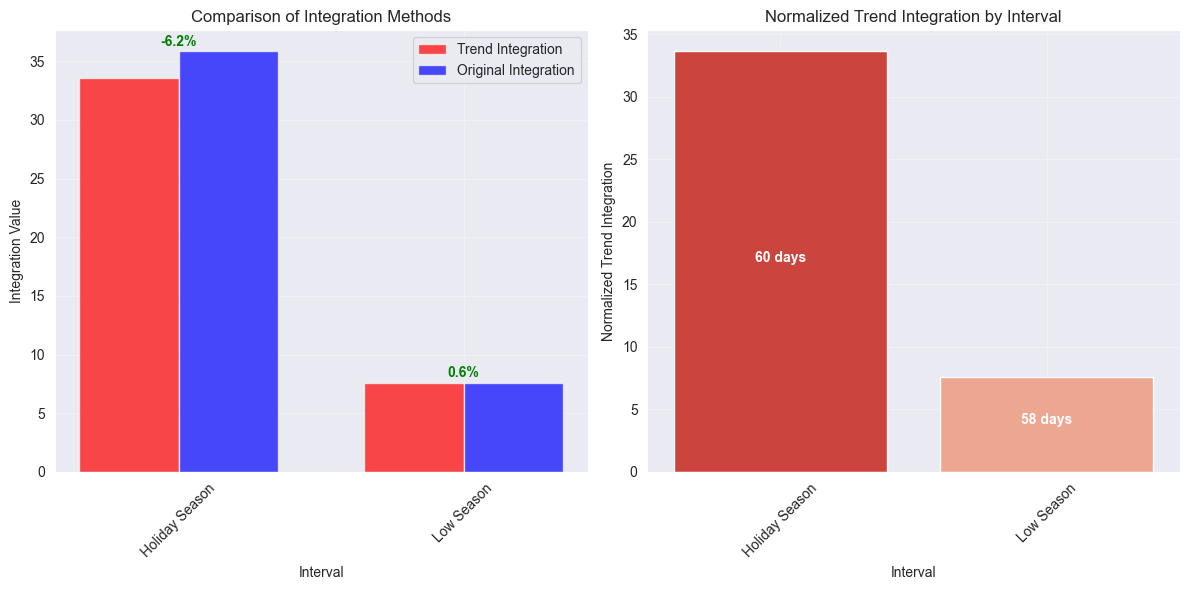

In [20]:
# Run demonstration with synthetic data
stl_ti, quarterly_results, seasonal_results = demonstrate_with_synthetic_data()

# Show all plots
plt.show()

# Input Data Requirements and Format
**Data Structure**

The implementation expects input data in the form of a pandas DataFrame with the following characteristics:

1.	Time Series Format: The data must contain at least two columns:
    - A date/time column with regular intervals (e.g., daily, weekly, monthly)
    - A numeric KPI value column
2.	Regular Time Intervals: The data should have observations at regular time intervals. While the code includes interpolation for missing values, consistent spacing produces the most reliable results.
3.	Sufficient History: For reliable seasonal decomposition, the data should span multiple seasonal cycles (e.g., several weeks for weekly seasonality, multiple years for annual seasonality).

```
        date  kpi_value
0 2022-01-01      45.2
1 2022-01-02      42.8
2 2022-01-03      48.7
3 2022-01-04      51.3
```


# Key Data Characteristics

For optimal results, the input data should exhibit:

1.	Clear Seasonal Pattern: The data should have identifiable seasonal patterns that repeat with consistent periodicity (e.g., weekly sales cycles, monthly billing patterns, quarterly reporting effects).
2.	Sufficient Length: The time series should contain at least 2-3 complete seasonal cycles to enable proper decomposition.
3.	Minimal Data Gaps: While the implementation handles missing values through interpolation, excessive gaps can compromise the quality of the decomposition.
4.	Trend Component: Ideally, the data should contain a meaningful trend component that represents the underlying direction of the KPI independent of seasonal fluctuations.
5.	Reasonable Noise Level: The data should have a signal-to-noise ratio that allows the decomposition to effectively separate components. Extremely noisy data may require additional preprocessing.

## Real-World KPI Examples

This methodology is suitable for various business KPIs exhibiting seasonality, such as:

1.	Retail Sales: Daily or weekly sales figures with day-of-week patterns and holiday effects
2.	Website Traffic: Hourly or daily visitor counts with day/night and weekday/weekend patterns
3.	Call Center Volume: Hourly or daily call counts with time-of-day and day-of-week patterns
4.	Manufacturing Output: Daily or weekly production figures with shift patterns and maintenance cycles
5.	Financial Metrics: Monthly revenue or profit figures with quarterly reporting cycles and annual seasonality
6.	Energy Consumption: Daily usage metrics with weather-related seasonality
7.	Customer Engagement: Weekly active user metrics with weekend/weekday patterns



## Validation Process and Code Explanation

The implementation validates the Seasonal-Trend Decomposition with Temporal Integration framework through several key steps:
1. Decomposition Validation
The `validate_decomposition()` method verifies the quality of the STL decomposition by checking:
	•	Seasonal Component Quality: High autocorrelation at the seasonal lag indicates effective capture of seasonal patterns
	•	Residual Quality: Low autocorrelation at the seasonal lag in the residuals confirms no remaining seasonality
	•	Component Independence: Low correlation between trend, seasonal, and residual components validates proper separation
	•	Conservation of Mean: Confirms that the trend component preserves the mean of the original series (Lemma 1)
2. Integration Comparison
The code implements multiple integration methods:
	•	Basic Temporal Integration: Direct application of the trapezoidal rule to the trend component
	•	Normalized Integration: Division by time interval length for comparable measures across periods
	•	Weighted Integration: Optional exponential weighting to emphasize recent observations
The `compare_integrations()` method quantifies the difference between trend integration and direct integration of the original series, demonstrating how seasonality can distort performance assessment when not properly accounted for.
3. Visualization
The implementation provides visualization functions that illustrate:
	•	The decomposition of the original series into trend, seasonal, and residual components
	•	The area under the curve representation of temporal integration
	•	Comparative analysis of integrations across different time periods
These visualizations help validate the theoretical properties discussed in the framework and demonstrate the practical benefits of the approach.

In [21]:

def run_analysis(data, year):
    stl_analysis = STLTemporalIntegration(
        data=data,
        date_column='date',
        value_column='kpi_value',
        period=12  # Monthly data with annual seasonality
    )

    # Perform decomposition
    stl_analysis.decompose(robust=True)
    # Validate decomposition
    validation_metrics = stl_analysis.validate_decomposition()
    # Define quarterly periods for comparison
    quarters = [
        (f'{year}-01-01', f'{year}-03-31', f'Q1 {year}'),
        (f'{year}-04-01', f'{year}-06-30', f'Q1 {year}'),
        (f'{year}-07-01', f'{year}-09-30', f'Q1 {year}'),
        (f'{year}-10-01', f'{year}-12-31', f'Q1 {year}'),
    ]

    # Compare temporal integrations
    results = stl_analysis.compare_integrations(quarters, normalize=True)

    # Visualize results
    stl_analysis.plot_decomposition()
    stl_analysis.plot_comparative_integrations(results)


Initialized with 132 observations and seasonal period of 12
Decomposition completed. Components extracted: trend, seasonal, remainder

Decomposition Validation:
Seasonal autocorrelation: 0.9413 (should be high)
Residual seasonal autocorrelation: -0.1949 (should be close to 0)
Trend-Seasonal correlation: -0.1624 (should be close to 0)
Trend-Residual correlation: 0.0089 (should be close to 0)
Seasonal-Residual correlation: -0.1607 (should be close to 0)
Original mean: 437457.2348
Trend mean: 438994.0464
Mean difference: 0.35% (should be close to 0)


/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:511: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:516: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:524: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


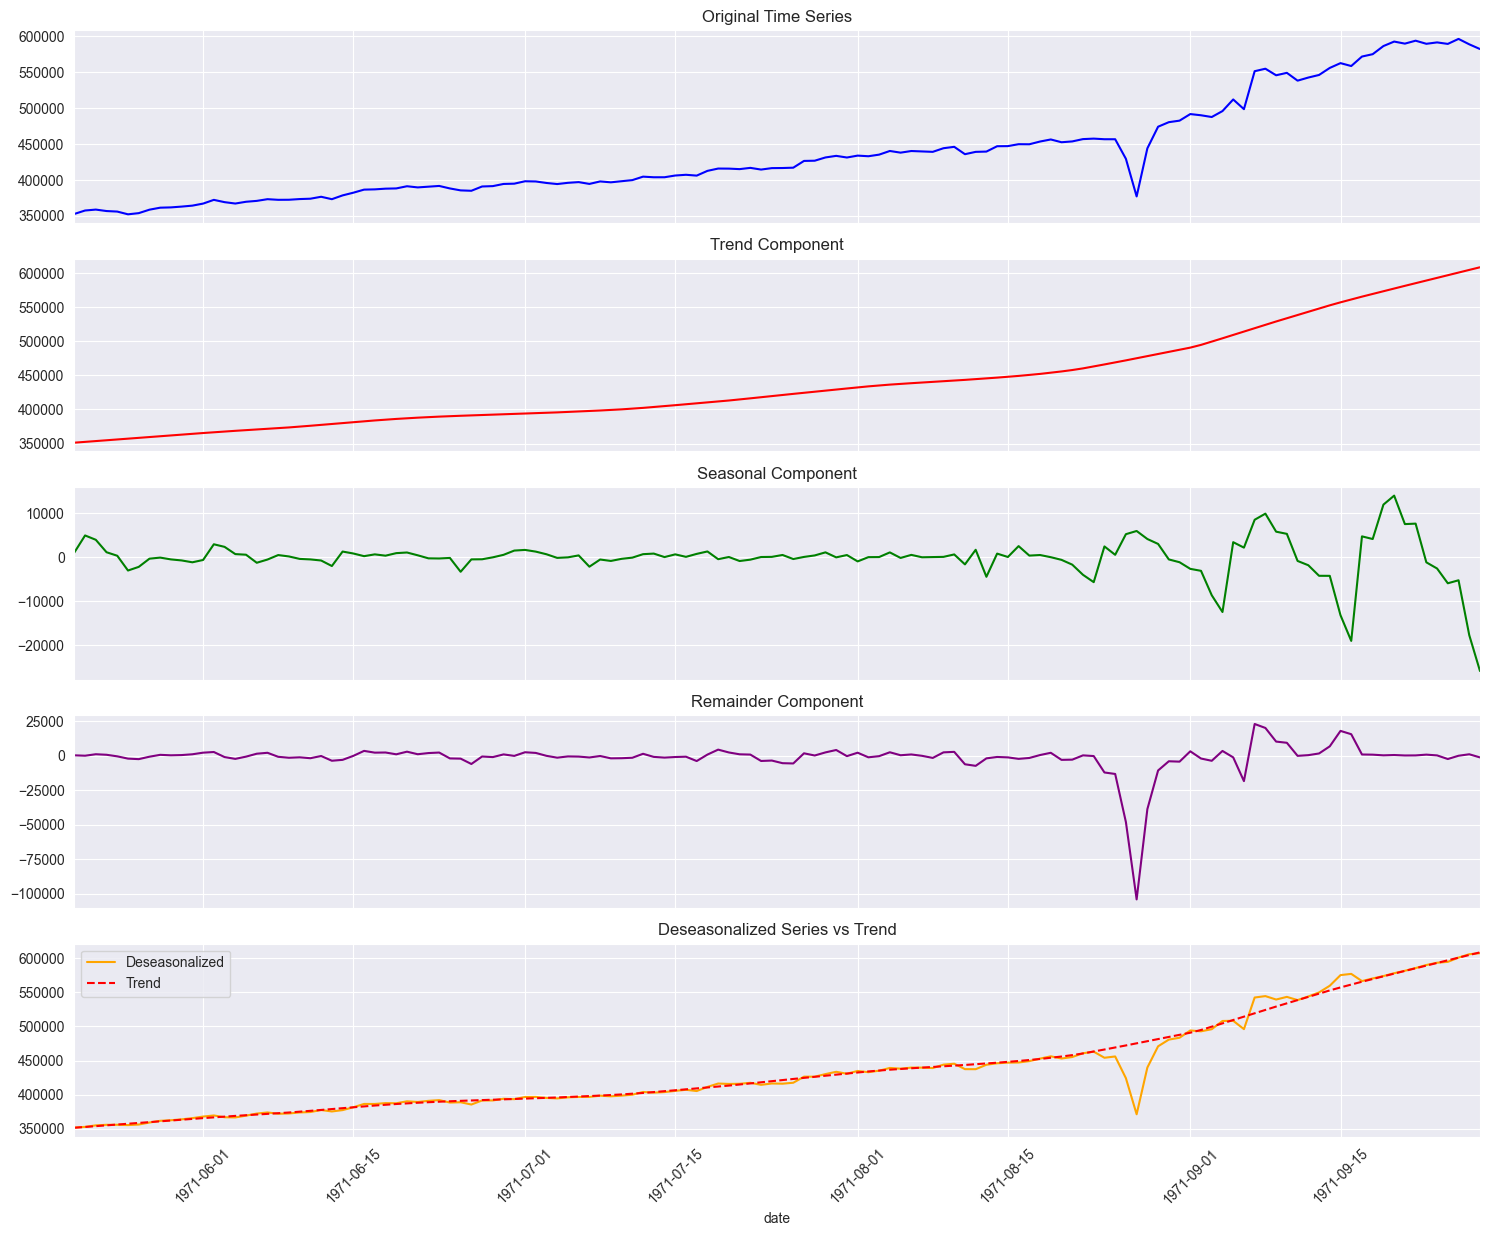

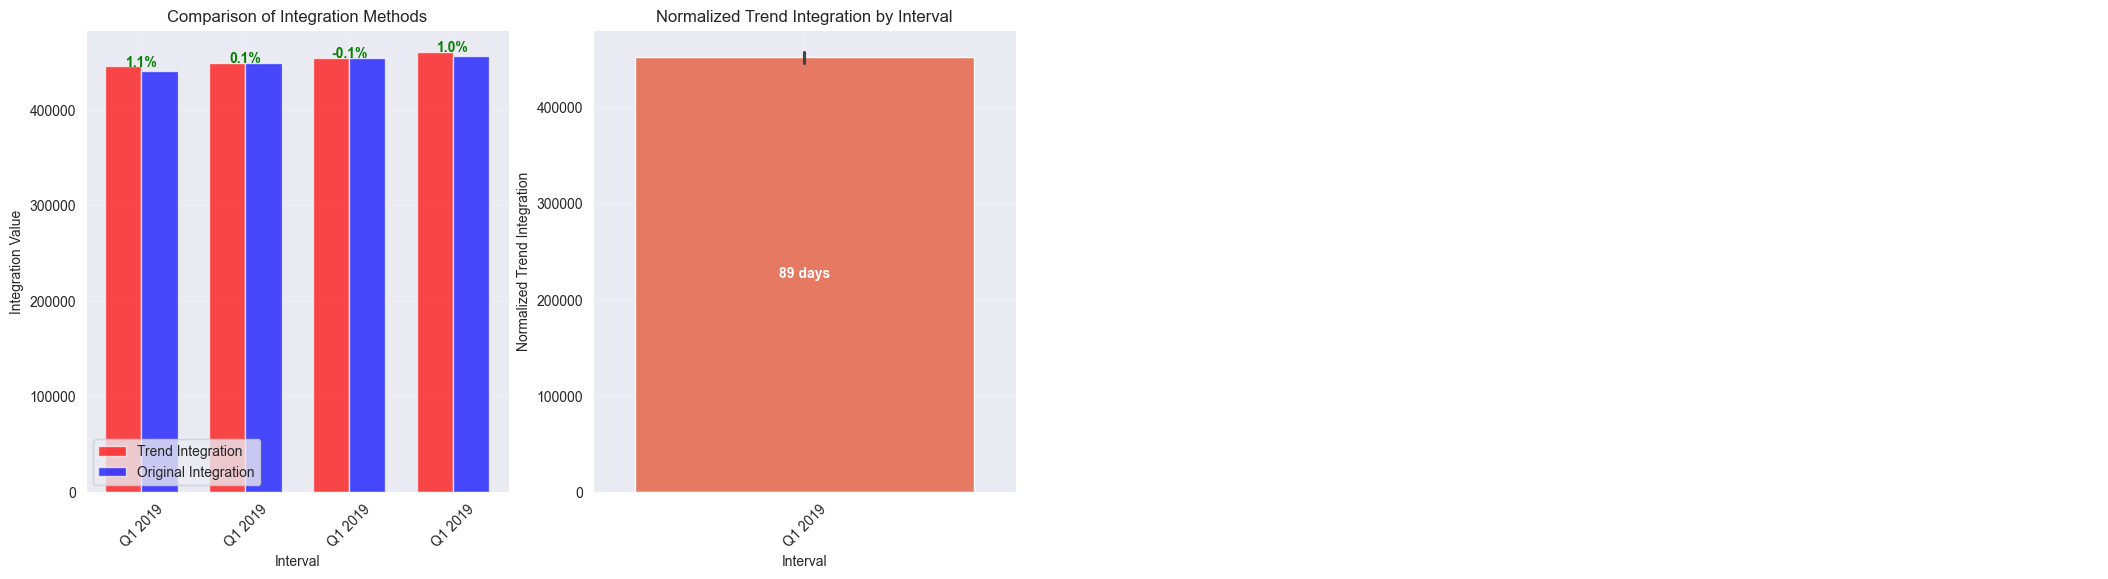

In [22]:
retail_sales_fred = pd.read_parquet('retail_sales_fred.parquet')
run_analysis(retail_sales_fred, 2019)

Initialized with 305 observations and seasonal period of 12
Decomposition completed. Components extracted: trend, seasonal, remainder

Decomposition Validation:
Seasonal autocorrelation: 0.9351 (should be high)
Residual seasonal autocorrelation: -0.0459 (should be close to 0)
Trend-Seasonal correlation: 0.0085 (should be close to 0)
Trend-Residual correlation: 0.0126 (should be close to 0)
Seasonal-Residual correlation: -0.0946 (should be close to 0)
Original mean: 29217.7308
Trend mean: 26745.9433
Mean difference: 8.46% (should be close to 0)


/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:511: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:516: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:524: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


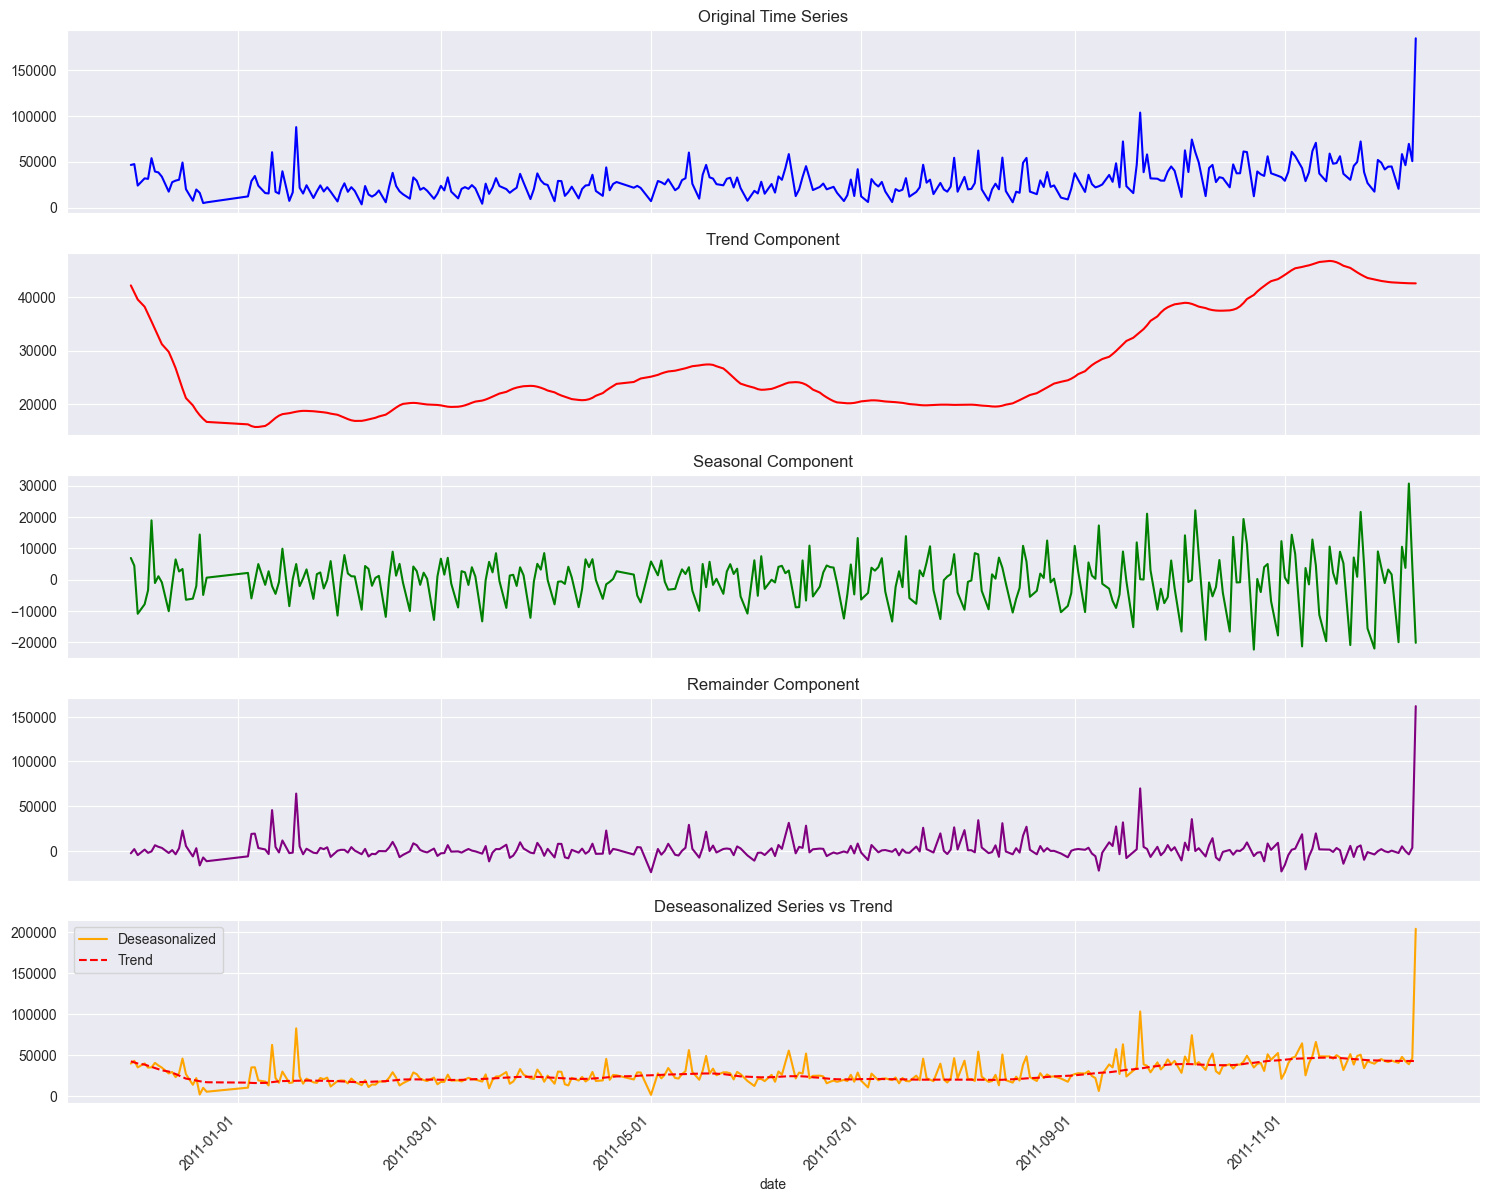

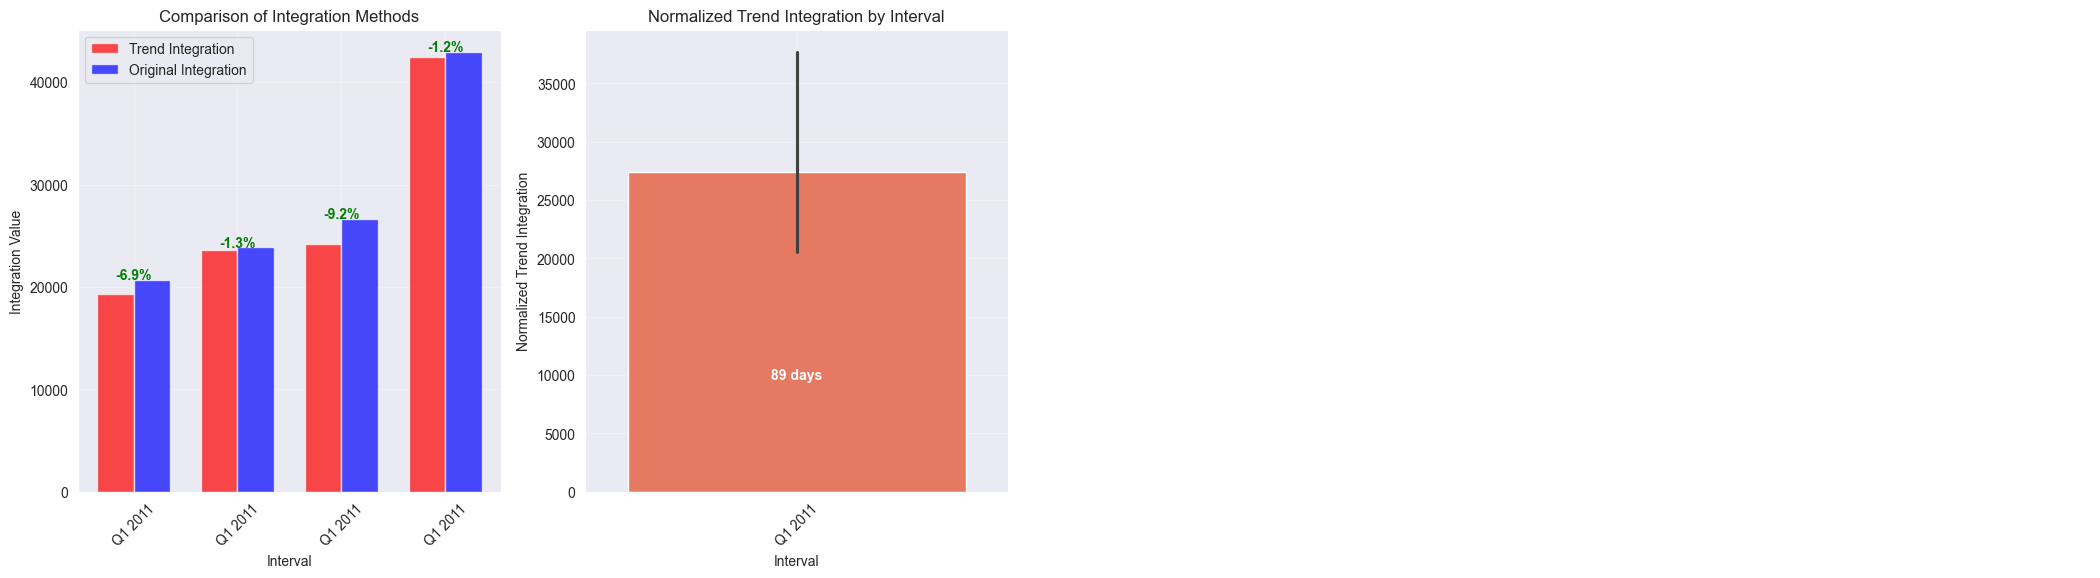

In [25]:
retail_sales_uci = pd.read_parquet('retail_sales_uci.parquet')
run_analysis(retail_sales_uci, 2011)

Initialized with 574 observations and seasonal period of 12
Decomposition completed. Components extracted: trend, seasonal, remainder

Decomposition Validation:
Seasonal autocorrelation: 0.1162 (should be high)
Residual seasonal autocorrelation: -0.2044 (should be close to 0)
Trend-Seasonal correlation: -0.0279 (should be close to 0)
Trend-Residual correlation: 0.0952 (should be close to 0)
Seasonal-Residual correlation: -0.1207 (should be close to 0)
Original mean: 388768.2927
Trend mean: 376606.7238
Mean difference: 3.13% (should be close to 0)


/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:511: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:516: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:524: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


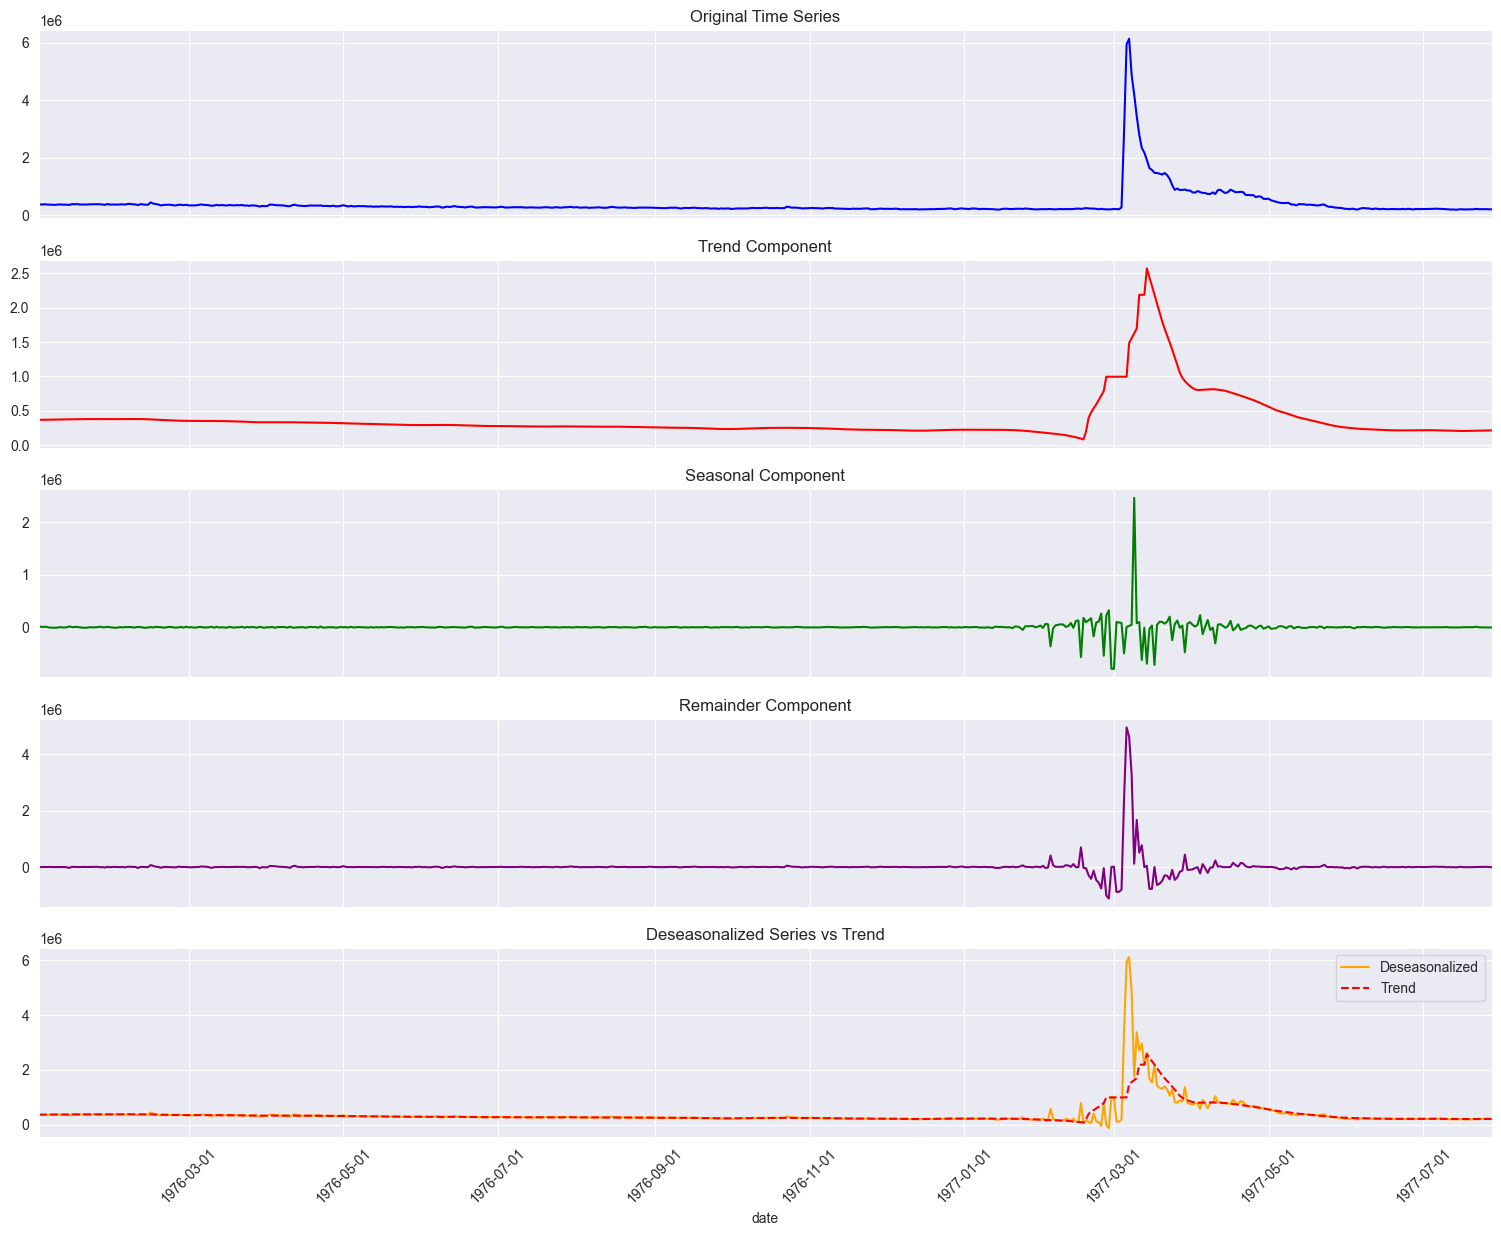

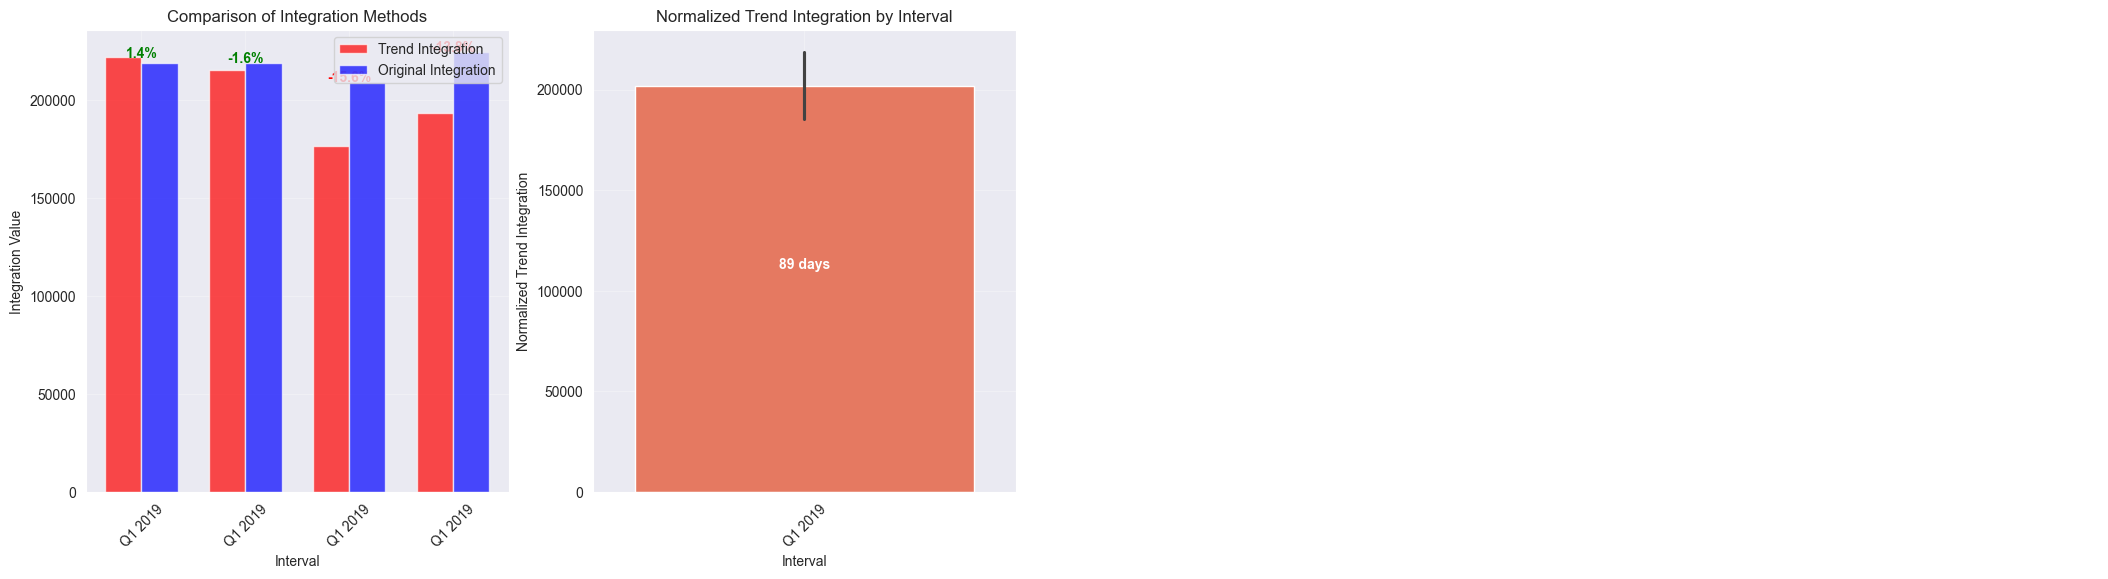

In [26]:
unemployment_claims = pd.read_parquet('unemployment_claims.parquet')
run_analysis(unemployment_claims, 2019)

Initialized with 366 observations and seasonal period of 12
Decomposition completed. Components extracted: trend, seasonal, remainder

Decomposition Validation:
Seasonal autocorrelation: 0.8520 (should be high)
Residual seasonal autocorrelation: -0.0613 (should be close to 0)
Trend-Seasonal correlation: -0.0300 (should be close to 0)
Trend-Residual correlation: -0.1139 (should be close to 0)
Seasonal-Residual correlation: -0.0843 (should be close to 0)
Original mean: 58420.2923
Trend mean: 57685.5010
Mean difference: 1.26% (should be close to 0)


/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:511: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:516: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:524: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


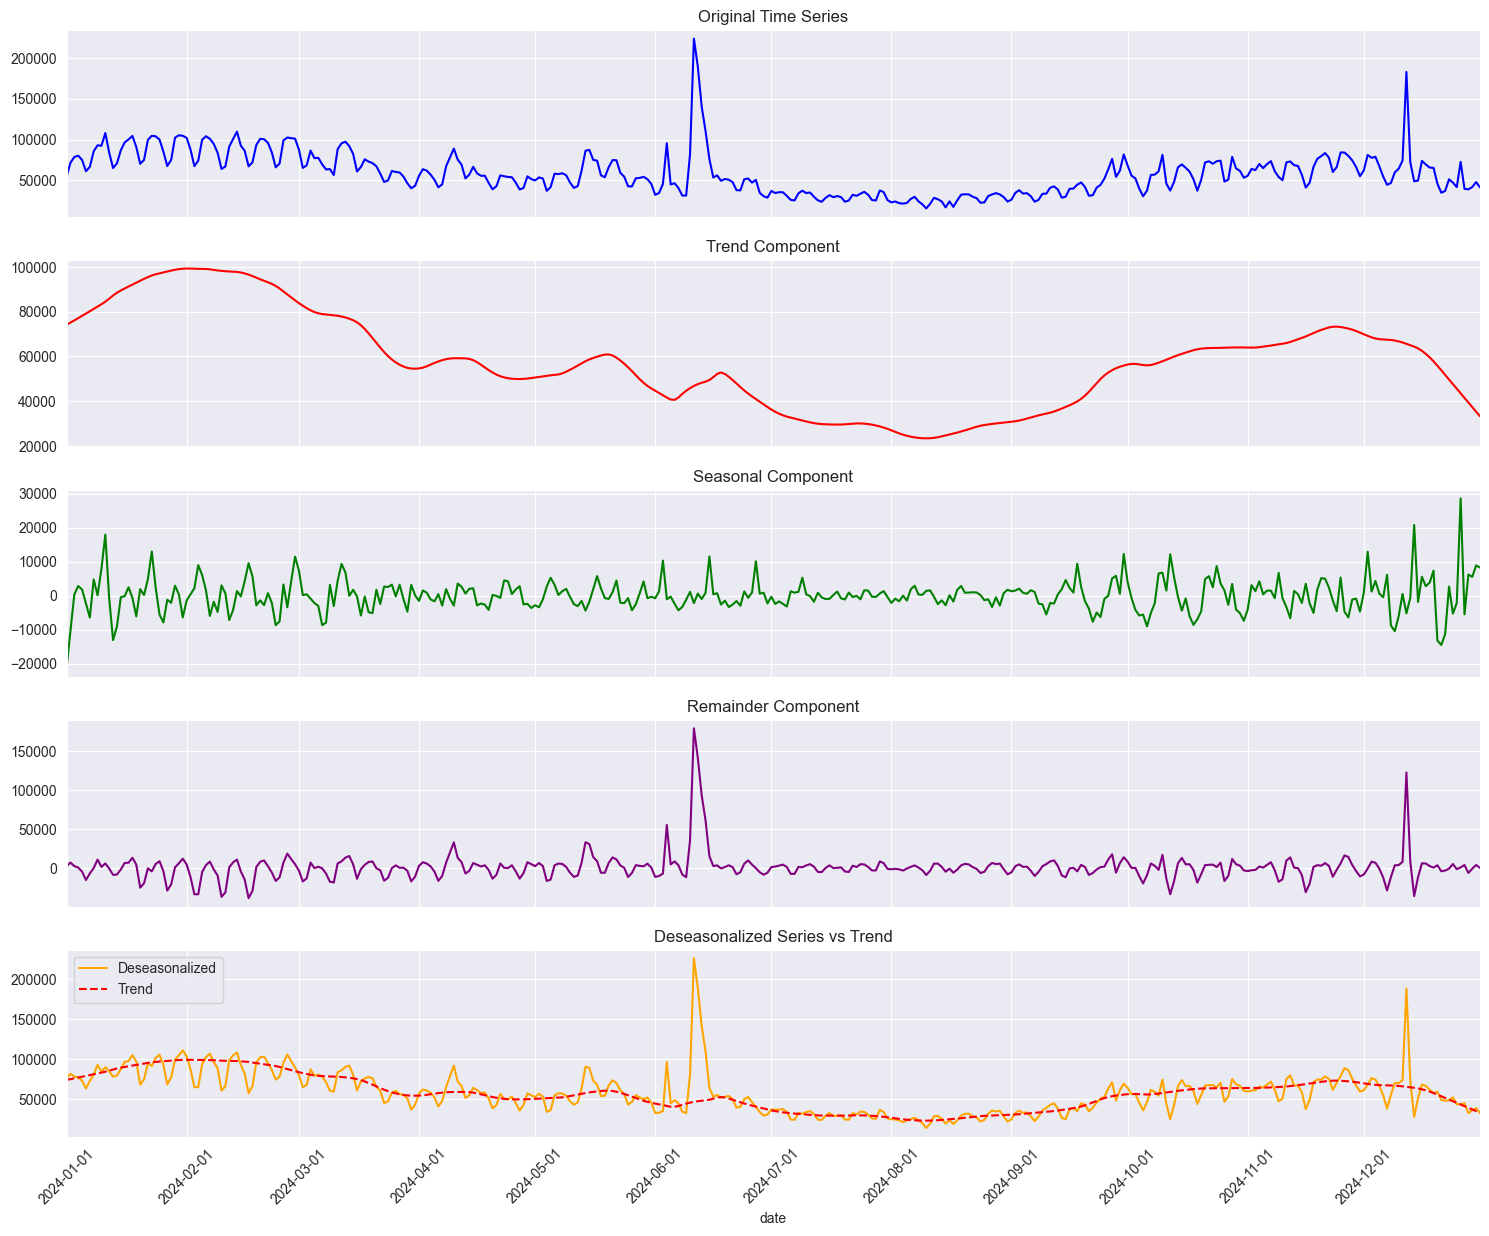

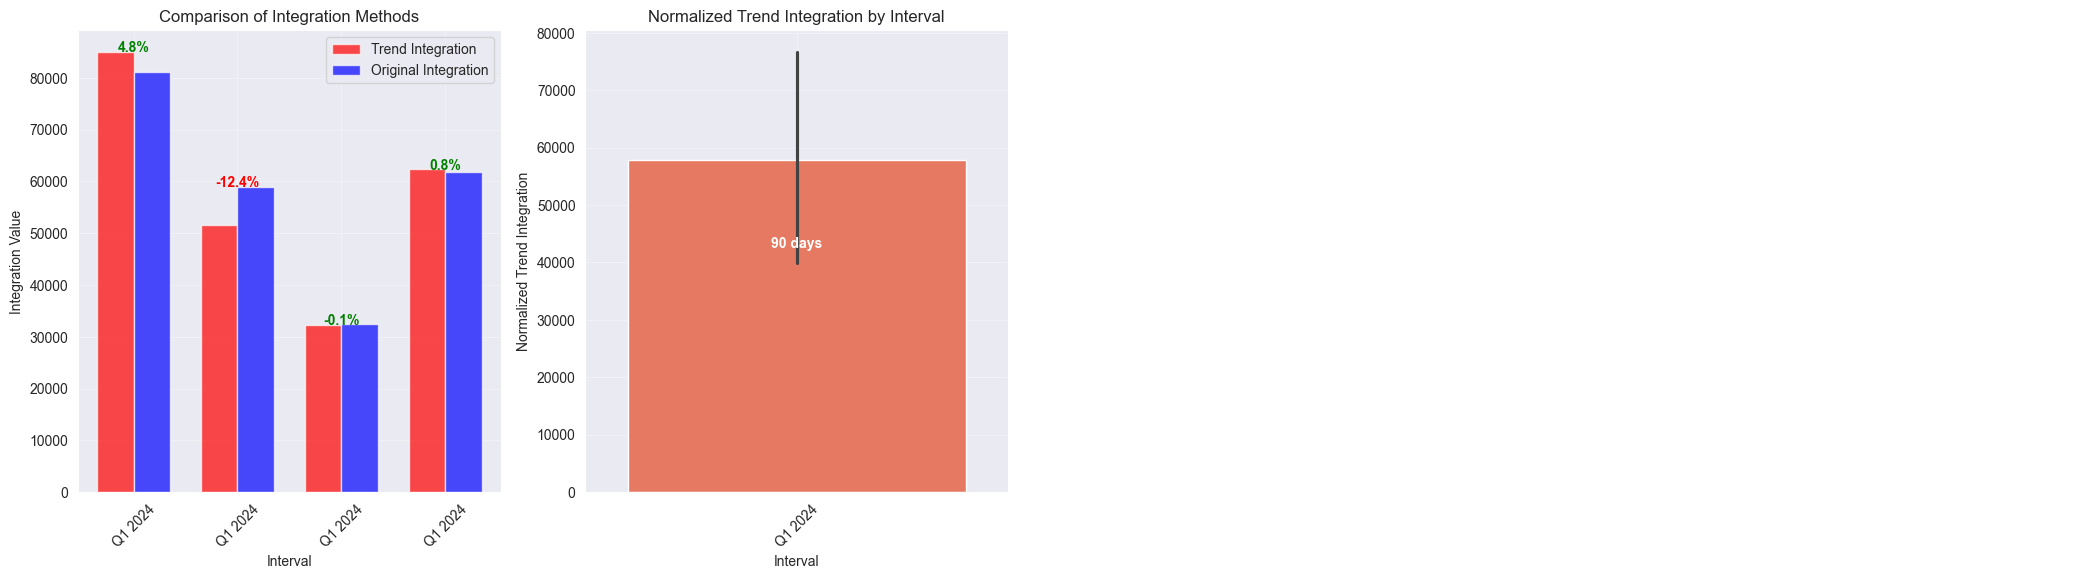

In [27]:
wiki_pageviews = pd.read_parquet('wikipedia_pageviews.parquet')
run_analysis(wiki_pageviews, 2024)